I have taken inspiration from online tutorial “Semantic Segmentation of BraTS2020” by DigitalSreeni, 2021, to implement my work.

# Importing and Installing Dependencies 

Download the dataset from the link --> "https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation?select=BraTS2020_TrainingData", unzip it, and load it on the hyperion server using FileZilla.

In [18]:
#!pip install nibabel
#!pip install split-folders
#!pip install segmentation-models-3d
#!pip install nilearn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Verifying if we have access to GPU or not.

import tensorflow as tf

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
Num GPUs Available:  1


In [3]:
# Importing all the necessary libraries.

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import splitfolders 
import os
from matplotlib import pyplot as plt
import random
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from keras.metrics import MeanIoU
import tensorflow.keras
from keras.models import load_model
#from nilearn import plotting

# Getting to know the Dataset

Loading sample image from the dataset for visualization.

In [4]:
DATASET_PATH = 'BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [5]:
image_t1 = nib.load(DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()

In [6]:
image_t1_mask = nib.load(DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Viewing whole nifti data, printing each slice from 3D image.

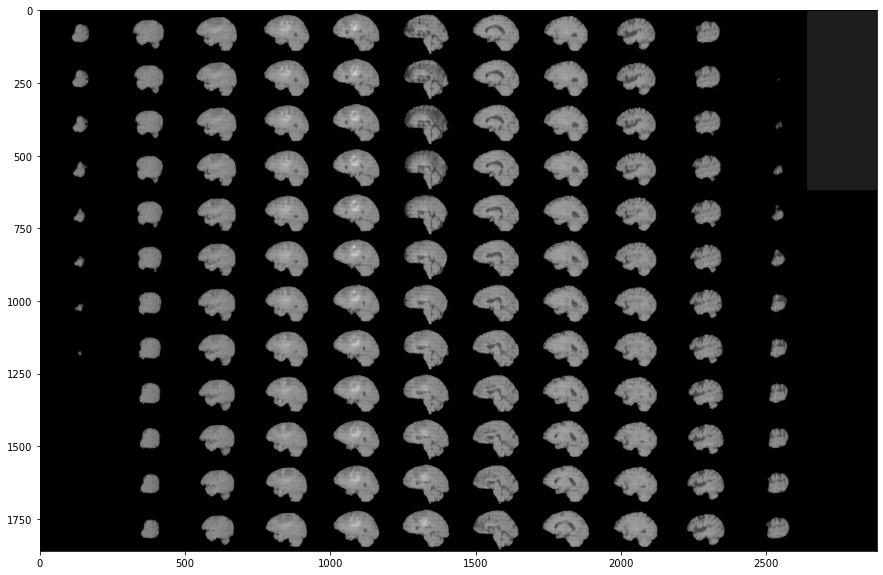

In [9]:
from skimage.util import montage 
from skimage.transform import rotate

# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

Viewing segment of tumor for each of the above slices.

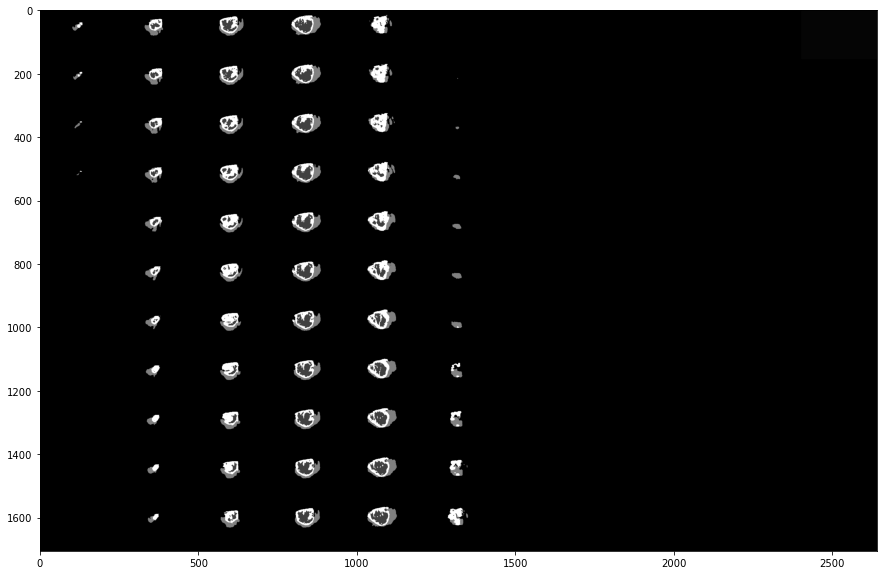

In [10]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t1_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

Now let us see the pixel value for image_t1.

In [11]:
print(image_t1.max())

1717.368408203125


Since the maximum pixel value is 1717.368, there is a need to rescale these values using MinMaxScaler.

In [12]:
scaler = MinMaxScaler()

Since scalers are applied to 1 dimensional image, so here we will have to reshape 3D volume to 1D volume and again reshape back 1D to its original 3D shape.

In [13]:
image_t1 = scaler.fit_transform(image_t1.reshape(-1, image_t1.shape[-1])).reshape(image_t1.shape)

In [14]:
print(image_t1.max())

1.0


Let us now load other channels as well for the 3D image.

In [15]:
image_t1ce = nib.load(DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

image_t2 = nib.load(DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

image_flair = nib.load(DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

In [16]:
mask = nib.load(DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
mask = mask.astype(np.uint8)
print(np.unique(mask))

[0 1 2 4]


Since the unique values (labels) in mask are 0, 1, 2, 4; these is a need to re-encode to 0, 1, 2, 3.
Hence, reasigning mask value (label) 4 to 3.

In [101]:
mask[mask==4] = 3 
print(np.unique(mask)) 

[0 1 2 3]


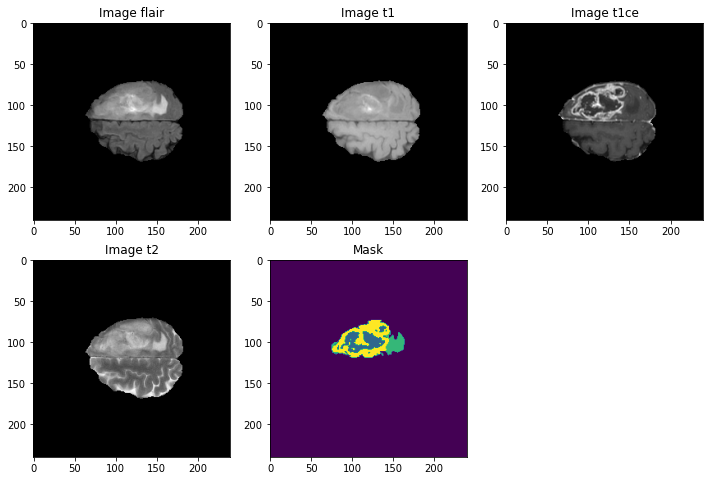

In [102]:
import random
n_slice=random.randint(0, mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Since we can see from the above image that T1 does'nt give any useful informatin about the tumour in the barin, therefore, let us just combine t1ce, t2 and flair only into a single multichannel image while ignoring t1 channel.

In [103]:
combined_image = np.stack([image_flair, image_t1ce, image_t2], axis=3)

In [104]:
print(combined_image.shape)

(240, 240, 155, 3)


Since the area outside the brain gives no information and is not useful to us, hence cropping the image to 128x128x128.

In [105]:
combined_image = combined_image[56:184, 56:184, 13:141] #Crop to 128x128x128x4

In [106]:
print(combined_image.shape)

(128, 128, 128, 3)


In [107]:
mask = mask[56:184, 56:184, 13:141]

In [108]:
print(mask.shape)

(128, 128, 128)


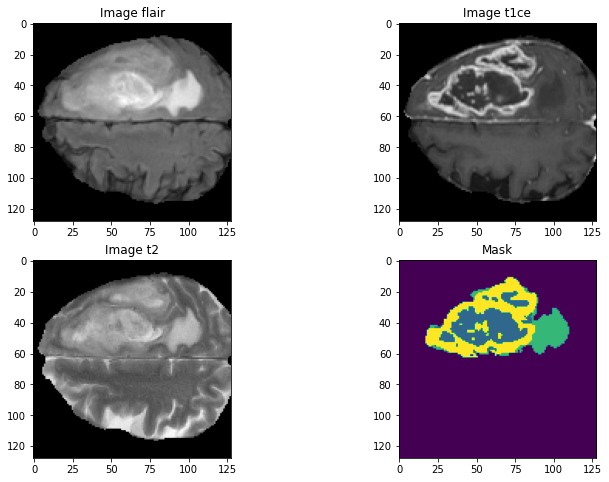

In [112]:
n_slice=random.randint(0, mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_image[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_image[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_image[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [113]:
np.save('BraTS2020/dataset/BraTS2020_TrainingData/combined255.npy', combined_image)

In [114]:
my_image = np.load('BraTS2020/dataset/BraTS2020_TrainingData/combined255.npy')

In [115]:
print(my_image.shape)

(128, 128, 128, 3)


In [116]:
#just to verify if the image got saved correctly.
combined_image == my_image

array([[[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        ...,

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ T

In [117]:
mask = to_categorical(mask, num_classes=4)

In [118]:
print(mask.shape)

(128, 128, 128, 4)


Whatever changes we made to the above image, now let us apply the same to all the images, i.e. Merge channels, Crop images to 128x128x128 and save.

In [119]:
t2_list = sorted(glob.glob('BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))


Now before running the next line of code, please go to the path "BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/" inside the dataset folder and go to "BraTS20_Training_355" and inside of that youll find 5 .nii files. There should be 4 files ending with t1, t1ce, t2, flair. However, the last remaining file, please rename it to "BraTS20_Training_355_seg.nii". We do this so that every image is consistent throughout and all have 5 files ending with t1, t1ce, t2, flair and seg.

In [120]:
mask_list = sorted(glob.glob('BraTS2020/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

Now applying MinMaxScaler to all the images and converting the mask to uint8 and reassigning mask value (label) 4 to 3.

In [121]:
for img in range(len(t2_list)):   #Using t2_list as all lists are of same length.
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    
    #cropping x, y, and z
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('BraTS2020/dataset/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2020/dataset/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")  

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

In [122]:
input_folder = 'BraTS2020/dataset/BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/'

Split with a ratio. To only split into training and validation set, set a tuple to `ratio`, i.e, `(.75, .25)` for 75% training and 25% valdation split.

In [123]:
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 688 files [01:33,  7.37 files/s]


Defining a Custom data generator to load our images for training the model.

In [4]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [5]:
#Testing the generator

train_img_dir = "BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/train/images/" # path to the image directory.
train_mask_dir = "BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/train/masks/" # path to the mask directory.
train_img_list=sorted(os.listdir(train_img_dir)) # sorting out the image list so that all the files are in ascending order and it matches with the contents of mask list.
train_mask_list = sorted(os.listdir(train_mask_dir)) # sorting out the mask list so that all the files are in ascending order and it matches with the contents of image list.

batch_size = 3

In [144]:
print(train_img_list) #verifying the list.

['image_0.npy', 'image_1.npy', 'image_10.npy', 'image_101.npy', 'image_102.npy', 'image_103.npy', 'image_104.npy', 'image_105.npy', 'image_106.npy', 'image_108.npy', 'image_11.npy', 'image_112.npy', 'image_115.npy', 'image_116.npy', 'image_117.npy', 'image_118.npy', 'image_119.npy', 'image_122.npy', 'image_123.npy', 'image_124.npy', 'image_125.npy', 'image_127.npy', 'image_128.npy', 'image_129.npy', 'image_13.npy', 'image_131.npy', 'image_134.npy', 'image_135.npy', 'image_136.npy', 'image_139.npy', 'image_14.npy', 'image_140.npy', 'image_143.npy', 'image_144.npy', 'image_146.npy', 'image_148.npy', 'image_150.npy', 'image_151.npy', 'image_152.npy', 'image_153.npy', 'image_155.npy', 'image_156.npy', 'image_157.npy', 'image_158.npy', 'image_159.npy', 'image_160.npy', 'image_161.npy', 'image_162.npy', 'image_163.npy', 'image_164.npy', 'image_165.npy', 'image_166.npy', 'image_168.npy', 'image_169.npy', 'image_17.npy', 'image_170.npy', 'image_171.npy', 'image_172.npy', 'image_173.npy', 'imag

In [145]:
print(train_mask_list) #verifying the list.

['mask_0.npy', 'mask_1.npy', 'mask_10.npy', 'mask_101.npy', 'mask_102.npy', 'mask_103.npy', 'mask_104.npy', 'mask_105.npy', 'mask_106.npy', 'mask_108.npy', 'mask_11.npy', 'mask_112.npy', 'mask_115.npy', 'mask_116.npy', 'mask_117.npy', 'mask_118.npy', 'mask_119.npy', 'mask_122.npy', 'mask_123.npy', 'mask_124.npy', 'mask_125.npy', 'mask_127.npy', 'mask_128.npy', 'mask_129.npy', 'mask_13.npy', 'mask_131.npy', 'mask_134.npy', 'mask_135.npy', 'mask_136.npy', 'mask_139.npy', 'mask_14.npy', 'mask_140.npy', 'mask_143.npy', 'mask_144.npy', 'mask_146.npy', 'mask_148.npy', 'mask_150.npy', 'mask_151.npy', 'mask_152.npy', 'mask_153.npy', 'mask_155.npy', 'mask_156.npy', 'mask_157.npy', 'mask_158.npy', 'mask_159.npy', 'mask_160.npy', 'mask_161.npy', 'mask_162.npy', 'mask_163.npy', 'mask_164.npy', 'mask_165.npy', 'mask_166.npy', 'mask_168.npy', 'mask_169.npy', 'mask_17.npy', 'mask_170.npy', 'mask_171.npy', 'mask_172.npy', 'mask_173.npy', 'mask_175.npy', 'mask_178.npy', 'mask_18.npy', 'mask_180.npy', '

In [146]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

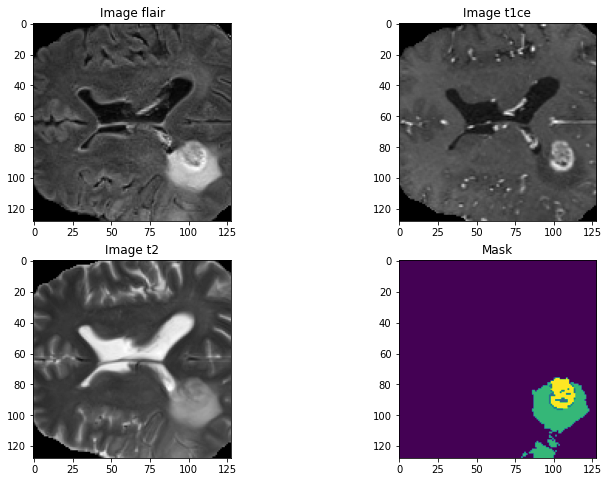

In [147]:
#Verify generator.
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Converting a 2D UNET model into 3D UNET Model.

In [6]:
kernel_initializer =  'he_uniform' 

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Building the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [7]:
#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)

2022-12-18 00:50:39.379259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 00:50:40.752231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 58334 MB memory:  -> device: 0, name: A100-PCIE-80GB, pci bus id: 0000:13:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 1312        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 128 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        dropout[0][0]                    
______________________________________________________________________________________________

In [8]:
print(model.input_shape) #verifying the input.


(None, 128, 128, 128, 3)


In [9]:
print(model.output_shape) #verifying the output.

(None, 128, 128, 128, 4)


# Training and Validation

Let us now define the image generators for training and validation.

In [9]:
train_img_dir = "BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [10]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [8]:
#Verifying the generator.
img, msk = train_img_datagen.__next__()

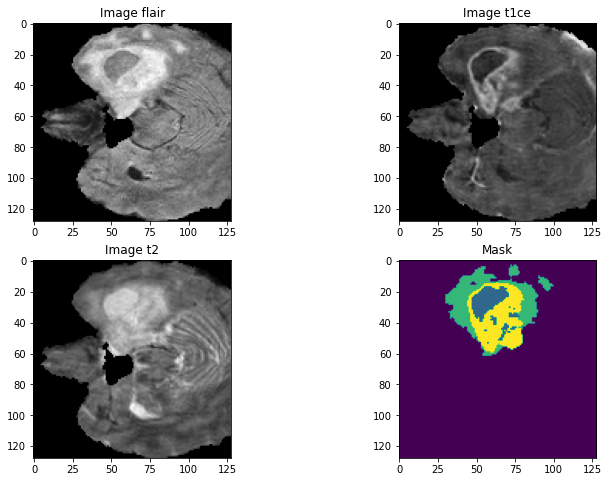

In [14]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Now we will be defining loss, metrics to be used for training.

In [11]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

Segmentation Models: using `tf.keras` framework.


In [12]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

# Training model on BraTS2020 Dataset using "Adamax" as an optimizer.

In [18]:
model_adamax = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, 128, 128, 128 1312        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 128 0           conv3d_19[0][0]                  
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 128, 128, 128 6928        dropout_9[0][0]                  
____________________________________________________________________________________________

In [19]:
LR = 0.001
optim = tensorflow.keras.optimizers.Adamax(LR)

In [20]:
model_adamax.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [21]:
print(model_adamax.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, 128, 128, 128 1312        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 128 0           conv3d_19[0][0]                  
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 128, 128, 128 6928        dropout_9[0][0]                  
____________________________________________________________________________________________

In [22]:
print(model_adamax.input_shape) #verify input parameter.

(None, 128, 128, 128, 3)


In [23]:
print(model_adamax.output_shape) #verify output parameter.

(None, 128, 128, 128, 4)


In [52]:
#print("Tensorflow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.6.0
Num GPUs Available:  1


In [27]:
history1=model_adamax.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=22,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

2022-12-08 16:43:55.008696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/22


2022-12-08 16:43:58.294590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-12-08 16:43:59.515853: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-12-08 16:43:59.676456: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


129/129 [==============================] - 114s 785ms/step - loss: 0.9370 - accuracy: 0.9452 - iou_score: 0.2396 - val_loss: 0.9180 - val_accuracy: 0.9458 - val_iou_score: 0.3210
Epoch 2/22
129/129 [==============================] - 108s 841ms/step - loss: 0.9172 - accuracy: 0.9449 - iou_score: 0.3175 - val_loss: 0.9132 - val_accuracy: 0.9328 - val_iou_score: 0.3581
Epoch 3/22
129/129 [==============================] - 108s 843ms/step - loss: 0.9034 - accuracy: 0.9526 - iou_score: 0.3594 - val_loss: 0.8979 - val_accuracy: 0.9436 - val_iou_score: 0.3740
Epoch 4/22
129/129 [==============================] - 108s 843ms/step - loss: 0.8998 - accuracy: 0.9429 - iou_score: 0.3853 - val_loss: 0.9008 - val_accuracy: 0.9099 - val_iou_score: 0.3812
Epoch 5/22
129/129 [==============================] - 108s 843ms/step - loss: 0.8884 - accuracy: 0.9529 - iou_score: 0.4168 - val_loss: 0.8806 - val_accuracy: 0.9542 - val_iou_score: 0.4397
Epoch 6/22
129/129 [==============================] - 110s 85

In [28]:
model_adamax.save('brats_UNET_adamax.hdf5')

# Training model on BraTS2020 Dataset using "SGD" as an optimizer.

In [24]:
model_sgd = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_38 (Conv3D)              (None, 128, 128, 128 1312        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 128 0           conv3d_38[0][0]                  
__________________________________________________________________________________________________
conv3d_39 (Conv3D)              (None, 128, 128, 128 6928        dropout_18[0][0]                 
____________________________________________________________________________________________

In [25]:
LR = 0.01
optim = tensorflow.keras.optimizers.SGD(LR)

In [26]:
model_sgd.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [27]:
print(model_sgd.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_38 (Conv3D)              (None, 128, 128, 128 1312        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 128 0           conv3d_38[0][0]                  
__________________________________________________________________________________________________
conv3d_39 (Conv3D)              (None, 128, 128, 128 6928        dropout_18[0][0]                 
____________________________________________________________________________________________

In [28]:
print(model_sgd.input_shape) #verify input parameter.
print(model_sgd.output_shape) #verify utput parameter.

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [53]:
#print("Tensorflow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.6.0
Num GPUs Available:  1


In [29]:
history2=model_sgd.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=22,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

2022-12-08 18:04:15.182708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/22


2022-12-08 18:04:18.393777: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-12-08 18:04:19.708954: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-12-08 18:04:19.877808: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


129/129 [==============================] - 129s 828ms/step - loss: 0.9925 - accuracy: 0.7688 - iou_score: 0.0714 - val_loss: 0.9747 - val_accuracy: 0.9503 - val_iou_score: 0.1506
Epoch 2/22
129/129 [==============================] - 103s 806ms/step - loss: 0.9701 - accuracy: 0.9513 - iou_score: 0.1445 - val_loss: 0.9669 - val_accuracy: 0.9503 - val_iou_score: 0.1606
Epoch 3/22
129/129 [==============================] - 103s 799ms/step - loss: 0.9636 - accuracy: 0.9520 - iou_score: 0.1811 - val_loss: 0.9607 - val_accuracy: 0.9503 - val_iou_score: 0.2340
Epoch 4/22
129/129 [==============================] - 109s 848ms/step - loss: 0.9579 - accuracy: 0.9520 - iou_score: 0.2297 - val_loss: 0.9546 - val_accuracy: 0.9503 - val_iou_score: 0.2403
Epoch 5/22
129/129 [==============================] - 111s 864ms/step - loss: 0.9519 - accuracy: 0.9520 - iou_score: 0.2355 - val_loss: 0.9478 - val_accuracy: 0.9503 - val_iou_score: 0.2469
Epoch 6/22
129/129 [==============================] - 109s 84

In [30]:
model_sgd.save('brats_UNET_sgd.hdf5')

# Training model on BraTS2020 Dataset using "Adam" as an optimizer.

In [36]:
model_adam = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_57 (Conv3D)              (None, 128, 128, 128 1312        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 128 0           conv3d_57[0][0]                  
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 128, 128, 128 6928        dropout_27[0][0]                 
____________________________________________________________________________________________

In [37]:
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

In [38]:
model_adam.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [39]:
print(model_adam.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_57 (Conv3D)              (None, 128, 128, 128 1312        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 128 0           conv3d_57[0][0]                  
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 128, 128, 128 6928        dropout_27[0][0]                 
____________________________________________________________________________________________

In [40]:
print(model_adam.input_shape) #verify input parameter.
print(model_adam.output_shape) #verify utput parameter.

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [54]:
#print("Tensorflow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.6.0
Num GPUs Available:  1


In [41]:
history3=model_adam.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=22,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/22
129/129 [==============================] - 105s 810ms/step - loss: 0.9619 - accuracy: 0.8495 - iou_score: 0.1783 - val_loss: 0.9355 - val_accuracy: 0.9504 - val_iou_score: 0.2493
Epoch 2/22
129/129 [==============================] - 108s 845ms/step - loss: 0.9312 - accuracy: 0.9482 - iou_score: 0.2521 - val_loss: 0.9243 - val_accuracy: 0.9418 - val_iou_score: 0.3212
Epoch 3/22
129/129 [==============================] - 108s 844ms/step - loss: 0.9242 - accuracy: 0.9428 - iou_score: 0.2891 - val_loss: 0.9195 - val_accuracy: 0.9379 - val_iou_score: 0.3198
Epoch 4/22
129/129 [==============================] - 108s 843ms/step - loss: 0.9149 - accuracy: 0.9414 - iou_score: 0.3245 - val_loss: 0.9062 - val_accuracy: 0.9480 - val_iou_score: 0.3806
Epoch 5/22
129/129 [==============================] - 109s 845ms/step - loss: 0.9048 - accuracy: 0.9410 - iou_score: 0.3708 - val_loss: 0.8982 - val_accuracy: 0.9365 - val_iou_score: 0.3979
Epoch 6/22
129/129 [==============================

In [42]:
model_adam.save('brats_UNET_adam.hdf5')

# Note:

Finally we have trained our Unet model using 3 different omtimizers, i.e. "Adamax", "SGD", and "Adam". 

This initial traning was done with an aim to find out which optimizer performs best with the Unet model and hence all 3 traning was done for a Batch size of 2 since it is a multi-channel image and for 22 epochs. 

The goal was to notice the performace difference with respect to the loss and validation loss, accuracy and validation accuracy, and iou score and validation iou_score.

The performance of SGD as an optimizer on Unet was extremely poor in comparion with Adamax and Adam as an optimizer.

Adamax and Adam as an optimizer performance was almost identical with surprisingly Adamax performing slightly better than Adam.

This result actually contradicted the literature survey of mine where Adam as an optimizer was termed as the best optimizer for semantic segmentation especially with respect to the Brain Tumour Segmentation.

For this reason, just to Double check, I decided to train my final models again using both the optimizers now for 100 epochs and then calculate and compare the Mean_IoU to decide which optimizer will be the best for the Brain tumour segmentation.


# Traning the model using Adamax as an optimizer for 100 epochs.

In [11]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), sm.metrics.IOUScore(threshold=0.5)]


Segmentation Models: using `tf.keras` framework.


In [12]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [13]:
model_final = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, 128, 128, 128 1312        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 128 0           conv3d_19[0][0]                  
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 128, 128, 128 6928        dropout_9[0][0]                  
____________________________________________________________________________________________

In [14]:
LR = 0.001
optim = tensorflow.keras.optimizers.Adamax(LR)

In [15]:
model_final.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [16]:
print(model_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, 128, 128, 128 1312        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 128 0           conv3d_19[0][0]                  
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 128, 128, 128 6928        dropout_9[0][0]                  
____________________________________________________________________________________________

In [17]:
print(model_final.input_shape) #verify input parameter.
print(model_final.output_shape) #verify utput parameter.

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [18]:
#print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
Num GPUs Available:  1


In [19]:
history4=model_final.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=2,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

2022-12-09 16:30:01.521722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-09 16:30:05.603288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-12-09 16:30:06.779739: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-12-09 16:30:06.888031: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


129/129 - 119s - loss: 0.9411 - accuracy: 0.9501 - precision: 0.9623 - recall: 0.8993 - false_negatives: 54463808.0000 - true_negatives: 1604131712.0000 - false_positives: 19063748.0000 - true_positives: 486601408.0000 - iou_score: 0.2277 - val_loss: 0.9302 - val_accuracy: 0.9530 - val_precision: 0.9714 - val_recall: 0.9230 - val_false_negatives: 13895082.0000 - val_true_negatives: 536171424.0000 - val_false_positives: 4893734.0000 - val_true_positives: 166459968.0000 - val_iou_score: 0.2476
Epoch 2/100
129/129 - 98s - loss: 0.9243 - accuracy: 0.9423 - precision: 0.9617 - recall: 0.9225 - false_negatives: 41917368.0000 - true_negatives: 1603320320.0000 - false_positives: 19875200.0000 - true_positives: 499147904.0000 - iou_score: 0.2802 - val_loss: 0.9042 - val_accuracy: 0.9467 - val_precision: 0.9548 - val_recall: 0.9421 - val_false_negatives: 10444419.0000 - val_true_negatives: 533014176.0000 - val_false_positives: 8051052.0000 - val_true_positives: 169910672.0000 - val_iou_score: 0.

In [20]:
# Saving the model just in case we want to load it again for prediction.

model_final.save('brats_UNET_final.hdf5')

Visualising the training results by plotting each one of them.

In [21]:
#from keras.models import load_model

In [22]:
#For predictions you do not need to compile the model, so ...
#model_AdamaxFinal = load_model('brats_UNET_final.hdf5', compile=False)

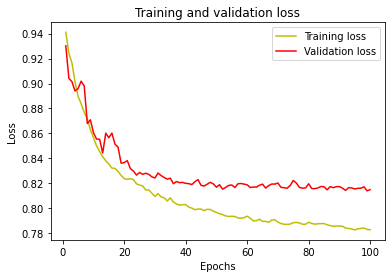

In [23]:
#plot the training and validation loss at each epoch

loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

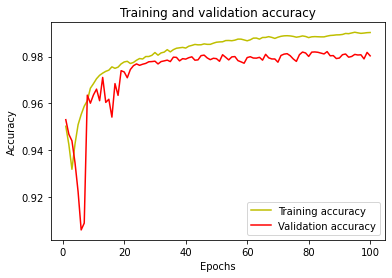

In [24]:
#plot the training and validation accuracy at each epoch

acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

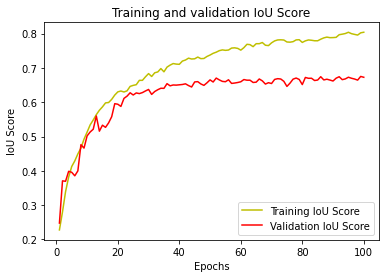

In [25]:
#plot the training and validation IoU score at each epoch

iou = history4.history['iou_score']
val_iou = history4.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU Score')
plt.plot(epochs, val_iou, 'r', label='Validation IoU Score')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

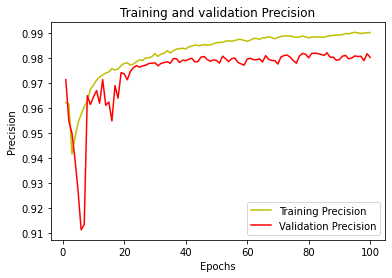

In [26]:
#plot the training and validation precision at each epoch

precsn = history4.history['precision']
val_precsn = history4.history['val_precision']

plt.plot(epochs, precsn, 'y', label='Training Precision')
plt.plot(epochs, val_precsn, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

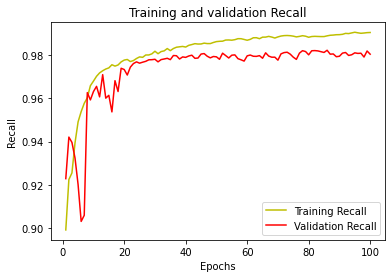

In [27]:
#plot the training and validation recall at each epoch

recll = history4.history['recall']
val_recll = history4.history['val_recall']

plt.plot(epochs, recll, 'y', label='Training Recall')
plt.plot(epochs, val_recll, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [28]:
#plot the training and validation f1-score at each epoch

#f1 = history4.history['f1-score']
#val_f1 = history4.history['val_f1-score']

#plt.plot(epochs, f1, 'y', label='Training F1-Score')
#plt.plot(epochs, val_f1, 'r', label='Validation F1-Score')
#plt.title('Training and validation F1-Score')
#plt.xlabel('Epochs')
#plt.ylabel('F1-Score')
#plt.legend()
#plt.show()

# Traning the model using Adam as an optimizer for 100 epochs.

In [15]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), sm.metrics.IOUScore(threshold=0.5)]


Segmentation Models: using `tf.keras` framework.


2022-12-09 07:38:03.364644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 07:38:04.138296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76428 MB memory:  -> device: 0, name: A100-PCIE-80GB, pci bus id: 0000:12:00.0, compute capability: 8.0


In [16]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [17]:
model_Afinal = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 1312        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 128 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        dropout[0][0]                    
______________________________________________________________________________________________

In [18]:
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

In [19]:
model_Afinal.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [20]:
print(model_Afinal.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 1312        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 128 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        dropout[0][0]                    
______________________________________________________________________________________________

In [21]:
print(model_Afinal.input_shape) #verify input parameter.
print(model_Afinal.output_shape) #verify utput parameter.

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [22]:
#print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
Num GPUs Available:  1


In [23]:
history5=model_Afinal.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=2,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

2022-12-09 07:39:27.014197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-09 07:39:31.247853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-12-09 07:39:32.400270: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-12-09 07:39:32.516966: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


129/129 - 124s - loss: 0.9484 - accuracy: 0.9257 - precision: 0.9558 - recall: 0.8367 - false_negatives: 88329384.0000 - true_negatives: 1602240768.0000 - false_positives: 20954684.0000 - true_positives: 452735872.0000 - iou_score: 0.2130 - val_loss: 0.9360 - val_accuracy: 0.9053 - val_precision: 0.9855 - val_recall: 0.8206 - val_false_negatives: 32361860.0000 - val_true_negatives: 538885888.0000 - val_false_positives: 2179342.0000 - val_true_positives: 147993216.0000 - val_iou_score: 0.2247
Epoch 2/100
129/129 - 100s - loss: 0.9297 - accuracy: 0.9334 - precision: 0.9741 - recall: 0.8992 - false_negatives: 54559892.0000 - true_negatives: 1610234752.0000 - false_positives: 12960614.0000 - true_positives: 486505408.0000 - iou_score: 0.2433 - val_loss: 0.9366 - val_accuracy: 0.8490 - val_precision: 0.9620 - val_recall: 0.8019 - val_false_negatives: 35720640.0000 - val_true_negatives: 535354528.0000 - val_false_positives: 5710774.0000 - val_true_positives: 144634400.0000 - val_iou_score: 0

In [24]:
model_Afinal.save('brats_UNET_Afinal.hdf5')

Visualising the training results by plotting each one of them.

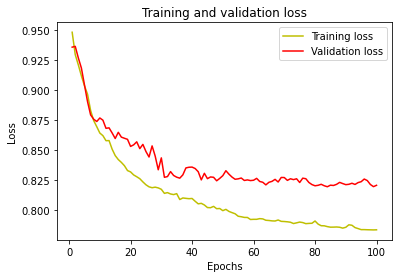

In [27]:
#plot the training and validation loss at each epoch

loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

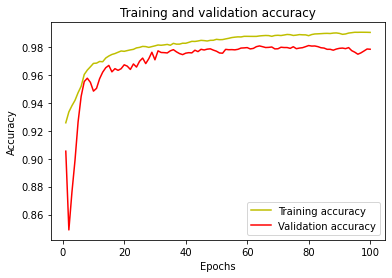

In [28]:
#plot the training and validation accuracy at each epoch

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

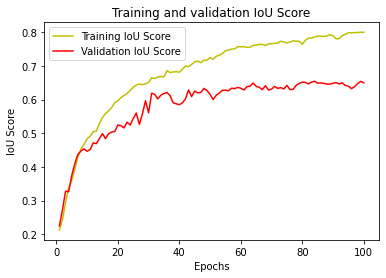

In [29]:
#plot the training and validation IoU score at each epoch

iou = history5.history['iou_score']
val_iou = history5.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU Score')
plt.plot(epochs, val_iou, 'r', label='Validation IoU Score')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

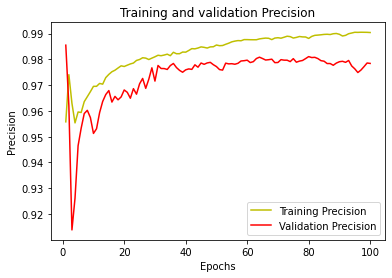

In [30]:
#plot the training and validation precision at each epoch

precsn = history5.history['precision']
val_precsn = history5.history['val_precision']

plt.plot(epochs, precsn, 'y', label='Training Precision')
plt.plot(epochs, val_precsn, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

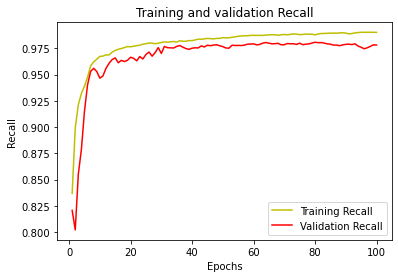

In [31]:
#plot the training and validation recall at each epoch

recll = history5.history['recall']
val_recll = history5.history['val_recall']

plt.plot(epochs, recll, 'y', label='Training Recall')
plt.plot(epochs, val_recll, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Calculating Mean_IoU for Unet model with Adam as optimizer.

In [ ]:
#from keras.models import load_model

In [ ]:
#For predictions you do not need to compile the model, so ...

#model_AdamFinal = load_model('brats_UNET_Afinal.hdf5', compile=False)

In [32]:
#Verify IoU on a batch of images from the test dataset

from keras.metrics import MeanIoU

In [33]:
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [34]:
#Verify generator.
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [36]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model_Afinal.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

In [37]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8214988


# Calculating MeanIoU for Unet model with Adamax as optimizer.

In [37]:
from keras.models import load_model

In [38]:
#For predictions you do not need to compile the model, so ...
model_AdamaxFinal = load_model('brats_UNET_final.hdf5', compile=False)

In [39]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU

from keras.metrics import MeanIoU

In [40]:
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [41]:
#Verify generator.
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [42]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model_AdamaxFinal.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

In [43]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8419774


From the above computations, we can notice that the Mean_IoU for model with "Adam" as an optimizer came out to be 0.821 which is lesser than the Mean_IoU for model with "Adamax" as an optimizer which is 0.841.



Now let us fix the optimizer as Adamax for our model. Till now we experimented with a customized loss function which was Dice loss and Focal loss added together. Let us now try CCE and Dice loss together as a loss function.

# Training the model using Adamax as an optimizer and CCE_Dice_loss as a loss function.

In [12]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
cce_loss = sm.losses.CategoricalCELoss()
total_loss = dice_loss + (1 * cce_loss)
#bce_j_loss = sm.losses.bce_jaccard_loss
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


Segmentation Models: using `tf.keras` framework.


In [13]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [15]:
model_Adamax_cced = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_38 (Conv3D)              (None, 128, 128, 128 1312        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 128 0           conv3d_38[0][0]                  
__________________________________________________________________________________________________
conv3d_39 (Conv3D)              (None, 128, 128, 128 6928        dropout_18[0][0]                 
____________________________________________________________________________________________

In [16]:
LR = 0.001
optim = tensorflow.keras.optimizers.Adamax(LR)

In [17]:
model_Adamax_cced.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [18]:
print(model_Adamax_cced.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_38 (Conv3D)              (None, 128, 128, 128 1312        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 128 0           conv3d_38[0][0]                  
__________________________________________________________________________________________________
conv3d_39 (Conv3D)              (None, 128, 128, 128 6928        dropout_18[0][0]                 
____________________________________________________________________________________________

In [19]:
print(model_Adamax_cced.input_shape) #verify input parameter.
print(model_Adamax_cced.output_shape) #verify utput parameter.

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [22]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
Num GPUs Available:  1


In [23]:
history6=model_Adamax_cced.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=2,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/100
129/129 - 91s - loss: 0.9566 - accuracy: 0.9546 - precision: 0.9760 - recall: 0.9381 - false_negatives: 33496852.0000 - true_negatives: 1610697728.0000 - false_positives: 12498297.0000 - true_positives: 507568256.0000 - iou_score: 0.2411 - f1-score: 0.2463 - val_loss: 0.9539 - val_accuracy: 0.9484 - val_precision: 0.9814 - val_recall: 0.9207 - val_false_negatives: 14295139.0000 - val_true_negatives: 537914560.0000 - val_false_positives: 3150599.0000 - val_true_positives: 166059952.0000 - val_iou_score: 0.2546 - val_f1-score: 0.2645
Epoch 2/100
129/129 - 91s - loss: 0.9445 - accuracy: 0.9569 - precision: 0.9750 - recall: 0.9429 - false_negatives: 30873560.0000 - true_negatives: 1610110080.0000 - false_positives: 13085800.0000 - true_positives: 510191712.0000 - iou_score: 0.2861 - f1-score: 0.3110 - val_loss: 0.9524 - val_accuracy: 0.9311 - val_precision: 0.9743 - val_recall: 0.9040 - val_false_negatives: 17306300.0000 - val_true_negatives: 536764576.0000 - val_false_positive

In [24]:
model_Adamax_cced.save('brats_UNET_Adamax_cced.hdf5')

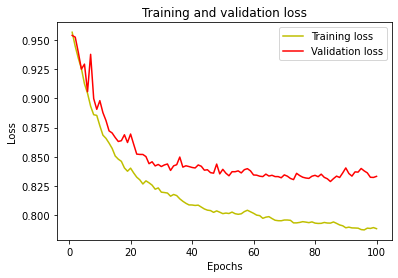

In [25]:
#plot the training and validation loss at each epoch

loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

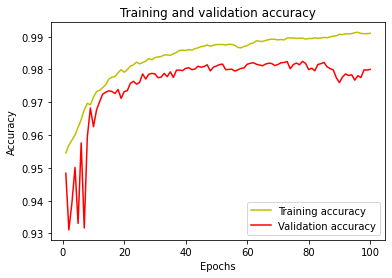

In [26]:
#plot the training and validation accuracy at each epoch

acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

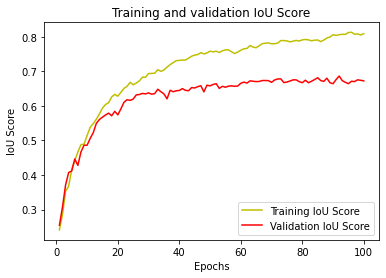

In [27]:
#plot the training and validation IoU score at each epoch

iou = history6.history['iou_score']
val_iou = history6.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU Score')
plt.plot(epochs, val_iou, 'r', label='Validation IoU Score')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

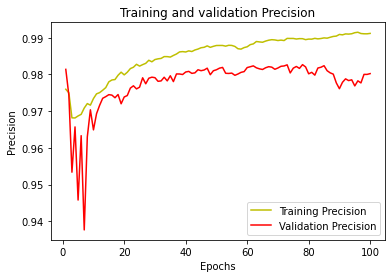

In [28]:
#plot the training and validation precision at each epoch

precsn = history6.history['precision']
val_precsn = history6.history['val_precision']

plt.plot(epochs, precsn, 'y', label='Training Precision')
plt.plot(epochs, val_precsn, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

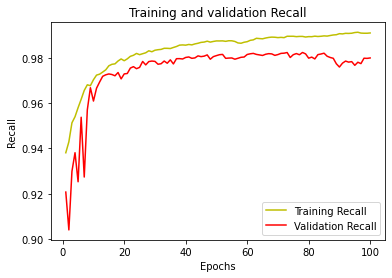

In [29]:
#plot the training and validation recall at each epoch

recll = history6.history['recall']
val_recll = history6.history['val_recall']

plt.plot(epochs, recll, 'y', label='Training Recall')
plt.plot(epochs, val_recll, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

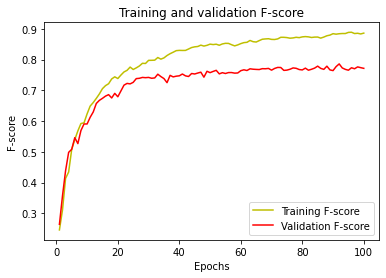

In [30]:
#plot the training and validation fscore at each epoch

fscr = history6.history['f1-score']
val_fscr = history6.history['val_f1-score']

plt.plot(epochs, fscr, 'y', label='Training F-score')
plt.plot(epochs, val_fscr, 'r', label='Validation F-score')
plt.title('Training and validation F-score')
plt.xlabel('Epochs')
plt.ylabel('F-score')
plt.legend()
plt.show()

# Calculating MeanIoU for Unet model with Adamax as optimizer and CCE_Dice_loss as a customised loss function.

In [5]:
from keras.models import load_model

In [6]:
#For predictions you do not need to compile the model, so ...
model_Adamax_cced = load_model('brats_UNET_Adamax_cced.hdf5', compile=False)

2022-12-18 09:37:17.876521: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 09:37:19.174171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 58334 MB memory:  -> device: 0, name: A100-PCIE-80GB, pci bus id: 0000:13:00.0, compute capability: 8.0


In [7]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU

from keras.metrics import MeanIoU

In [11]:
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [12]:
#Verify generator.
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [13]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model_Adamax_cced.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

2022-12-18 09:38:08.164435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-18 09:38:09.896094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-12-18 09:38:11.232980: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-12-18 09:38:11.311769: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [14]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.82893217


Just to give an overview, we trainined two models for 100 epochs, both with Adamax as an optimizer, the "first model" with customised loss function of Dice loss + Focal loss and the "second model" with customised loss function of Dice loss + Categorical Cross Entropy loss.

The first model with customised loss function of Dice loss + Focal loss gave a mean IoU score of 0.8419.
The second model with customised loss function of Dice loss + Categorical Cross Entropy loss gave a mean IoU score of o.8289.

Therefore, now we will use the trained model with Adamax as an optimizer and Dice loss + Focal loss as customised loss function for making some predictions on the test images.

# Now predicting on a few test images.

In [16]:
#from keras.models import load_model

In [17]:
#For predictions you do not need to compile the model.

#model_AdamaxFinal = load_model('brats_UNET_final.hdf5', compile=False)

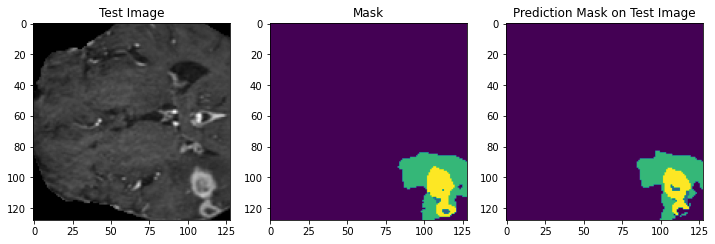

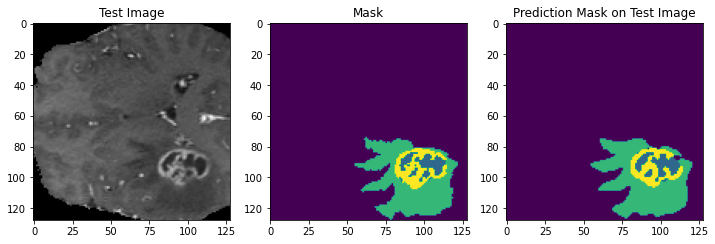

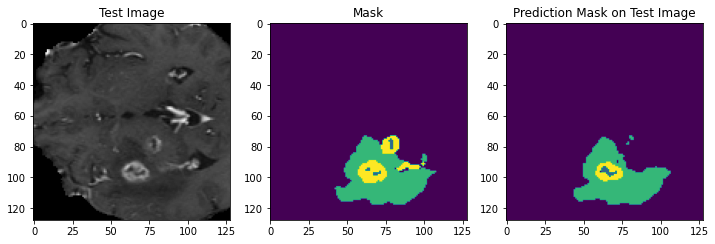

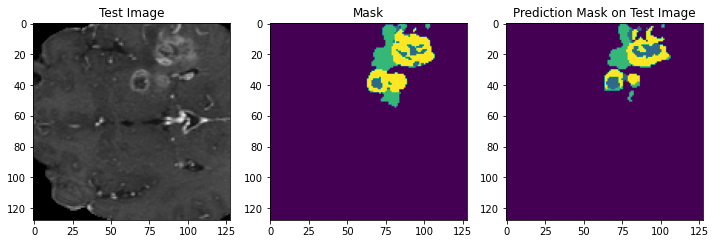

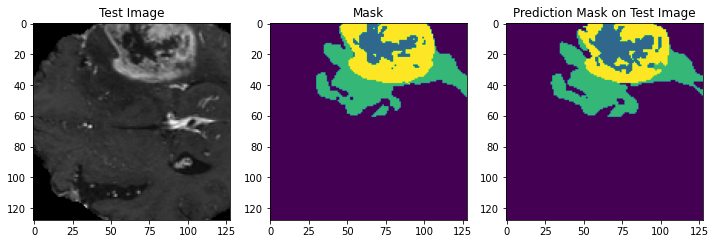

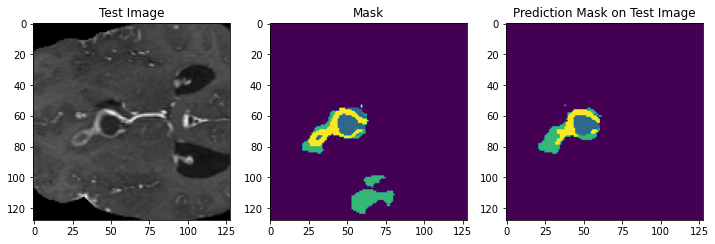

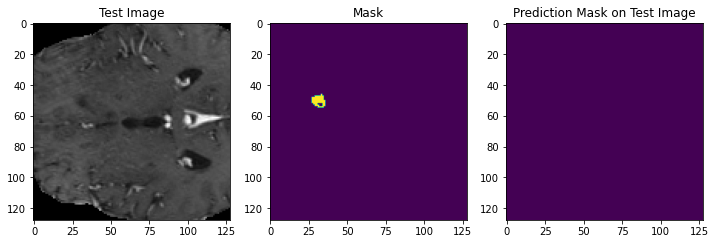

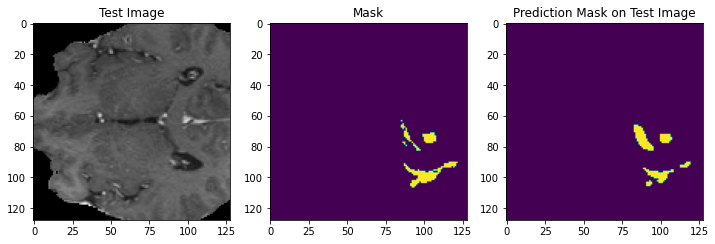

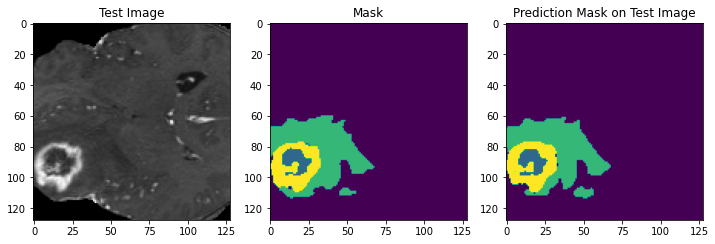

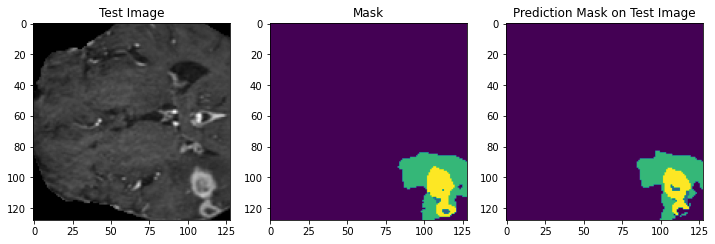

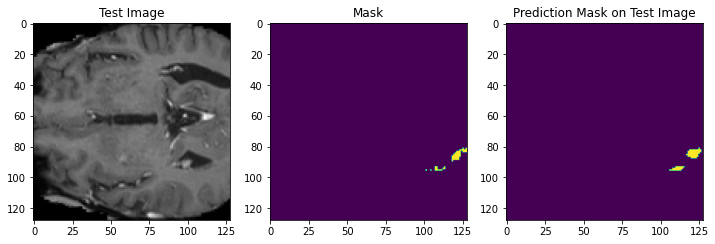

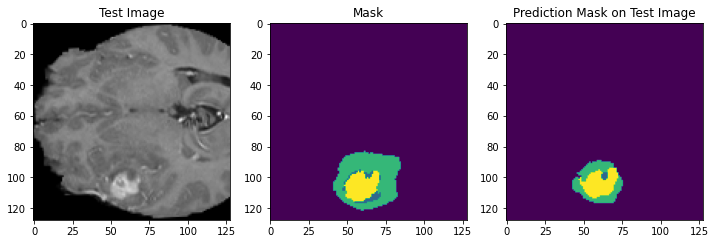

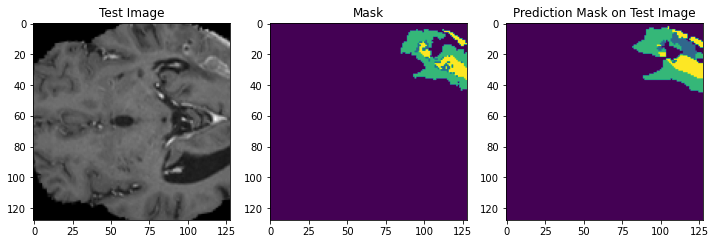

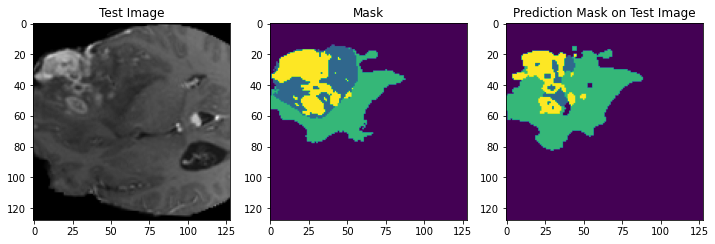

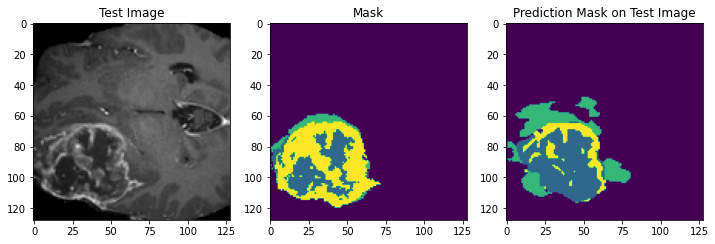

In [27]:
#Predict on a few test images.
#Loading the images in a list so that its easier to get the results using for loop rather than printing out the same code multiple times for test result on different images.

img_num_list = [126, 82, 100, 110, 111, 113, 114, 12, 120, 126, 130, 132, 133, 137, 142]

for i in range(len(img_num_list)):
    
    test_img = np.load("BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num_list[i])+".npy")

    test_mask = np.load("BraTS2020/dataset/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num_list[i])+".npy")
    test_mask_argmax=np.argmax(test_mask, axis=3)

    test_img_input = np.expand_dims(test_img, axis=0)
    test_prediction = model_AdamaxFinal.predict(test_img_input)
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

    #Plotting individual slices from test predictions for verification.

    n_slice = 55
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Test Image')
    plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
    plt.subplot(232)
    plt.title('Mask')
    plt.imshow(test_mask_argmax[:,:,n_slice])
    plt.subplot(233)
    plt.title('Prediction Mask on Test Image')
    plt.imshow(test_prediction_argmax[:,:, n_slice])
    plt.show()

